# Homework: Robust Regression and Equity Beta
Robert Hatem

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import time
import h5py
import statsmodels.api as sm
import copy
%matplotlib inline

In [3]:
# API key
quandl.ApiConfig.api_key = "wFcUAbwJv3FbxzDwExsY"

In [4]:
# for quandl data
@functools.lru_cache(maxsize=16)
def fetch_quandl(my_securities, start_date="2011-01-01", end_date="2018-01-01"):
    #print("Fetching from Quandl")
    if len(my_securities) != 1:
        qdata = quandl.get(list(my_securities), start_date=start_date, end_date=end_date, returns="pandas")
    elif len(my_securities) == 1:
        my_securities = my_securities[0]
        qdata = quandl.get(list(my_securities), start_date="2010-12-01", end_date="2018-01-01", returns="pandas")
    return qdata

# Data Processing
The data processing steps are as follows:
* Get excel with top 40 tickers (or less) of each ETF
* In a dictionary, collect the ETFs for each stock
* Upload returns for each ticker
* Note that I use 60 days for Jan-March. The first 45 days are in-sample and the last 15 days are the out-of-sample.

The holdings for each of the 9 ETFs are read in from their excel sheet.

In [9]:
# read in all tabs as dictionary
etf_holdings = pd.read_excel('ETF Data.xlsx', sheet_name=None)

print('ETF :','Number of tickers\n')
for key, value in etf_holdings.items():
    print(key, ": ", value.Ticker.unique().shape[0])

ETF : Number of tickers

XLU :  29
VOX :  40
SMH :  25
XBI :  40
XLF :  40
XOP :  40
OIH :  24
XRT :  40
XLV :  40


Turn the dictionary into one large dataframe by concatenating.

In [10]:
# Concatenate all ETF holdings together
holdings = etf_holdings['XLU'].copy()
for key, value in etf_holdings.items():
    if key=='XLU': continue
    else:
        holdings = pd.concat([holdings, value])
        
# change order of columns
cols = holdings.columns.tolist()
cols = [cols[2], cols[1], cols[0]]
holdings = holdings[cols]

holdings.head()

,ETF,Ticker,Stock
0,XLU,NEE,NextEra Energy Inc.
1,XLU,DUK,Duke Energy Corporation
2,XLU,D,Dominion Energy Inc
3,XLU,SO,Southern Company
4,XLU,EXC,Exelon Corporation


Now, for each ticker, list the ETFs in which it is contained in the its top 40.

In [11]:
# find ETFs for each ticker
ticker_etfs = {}
for ticker in holdings.Ticker.unique():
    if type(ticker)!=str: print(ticker)
    ticker_etfs[ticker] = ['QQQ', 'SPY'] + list(holdings.loc[holdings.Ticker==ticker].ETF.unique())
    
print('For example:\n')
print('DUK is in ETFs',ticker_etfs['DUK'])

For example:

DUK is in ETFs ['QQQ', 'SPY', 'XLU']


Now upload the adjusted closing prices of the ETFs from Quandl for each stock, so we can calculate returns.

In [12]:
# upload ETF returns
etfs = holdings.ETF.unique().tolist()
etfs = ['QQQ', 'SPY'] + etfs
query = tuple(['EOD/'+e+'.11' for e in etfs])

# query Quandl
etf_adj_close = fetch_quandl(query, start_date="2019-01-01", end_date="2019-03-31")

# rename cols
etf_adj_close.columns = etfs

etf_adj_close.head()

,QQQ,SPY,XLU,VOX,SMH,XBI,XLF,XOP,OIH,XRT,XLV
Date,,,,,,,,,,,
2019-01-02,154.599123,249.088142,51.628311,74.911264,87.92,72.86,23.899113,27.223245,14.37,41.443272,84.885428
2019-01-03,149.548299,243.144197,51.618384,73.902997,82.64,71.21,23.361831,27.033710,14.49,40.865040,83.161816
2019-01-04,155.946674,251.288497,52.382733,76.967730,86.49,75.02,24.137906,28.559967,15.19,42.121199,85.642622
2019-01-07,157.803301,253.269812,52.025375,77.686495,88.16,79.50,24.167755,29.537570,15.78,43.427205,85.971404
2019-01-08,159.230708,255.649381,52.670605,79.004230,87.65,80.48,24.187654,29.806909,15.94,43.806047,86.638930


Upload the adjusted closing prices of the stocks from Quandl. I did this once then saved in a csv file.

In [13]:
# tickers returns
ticker_list = list(ticker_etfs.keys())
query1 = tuple(['EOD/'+t+'.11' for t in ticker_list])

# get ticker prices from Quandl (~80 secs)
t0 = time.time()
#df_temp = fetch_quandl(query1, start_date="2019-01-01", end_date="2019-03-31")
#df_temp.columns = ticker_list
#df_temp.to_csv('ticker_returns_all.csv', index_label="Date")

df_temp1 = pd.read_csv('ticker_returns_all.csv').set_index('Date')
df_temp1.index = pd.to_datetime(df_temp1.index)
print(time.time()-t0, 'seconds')

df_temp1.head()

0.11939501762390137 seconds


,NEE,DUK,D,SO,EXC,AEP,SRE,PEG,XEL,ED,...,HUM,HCA,ZBH,MCK,ALGN,CNC,CERN,A,IDXX,IQV
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,168.701171,82.922975,70.309318,42.694559,43.419285,71.749948,105.945649,50.428283,47.874749,73.795695,...,281.001482,121.410717,102.087019,112.724274,202.12,56.500,51.87,65.558176,182.46,114.31
2019-01-03,168.283963,82.893604,69.973477,43.300017,43.468547,71.582721,106.431911,50.418362,47.686110,73.982295,...,269.136332,119.097372,100.240509,112.594672,184.78,54.960,50.70,63.143033,178.02,109.96
2019-01-04,171.383225,83.578918,71.326719,43.661339,43.961164,72.241790,109.617425,50.964015,48.152745,75.180469,...,276.041869,123.036041,103.664038,113.980422,186.71,56.765,52.23,65.328638,187.43,115.07
2019-01-07,171.134887,83.226471,70.635282,43.563684,44.039983,71.838479,109.597578,51.073146,47.944248,74.090328,...,276.001952,124.083029,103.703962,115.007272,189.92,57.250,51.93,66.715848,186.89,117.20
2019-01-08,172.386512,84.274022,71.455129,44.803897,44.719794,72.723795,112.664008,51.271565,48.500239,74.542098,...,274.355401,125.828009,101.378358,117.350087,192.95,58.040,53.13,67.693882,189.29,119.63


Create a dictionary with the ticker symbols as keys, and a dataframe with the stock's returns and the returns of its corresponding ETFs as a dataframe as the value.

In [14]:
# datasets for each ticker
ticker_returns_temp = {}
for i, ticker in enumerate(ticker_etfs.keys()):
    if i%50==0: print(i)
    df_temp2 = df_temp1.loc[:, [ticker]].copy().merge(etf_adj_close[ticker_etfs[ticker]], left_index=True, right_index=True, how='left').pct_change()
    ticker_returns_temp[ticker] = df_temp2

0
50
100
150
200
250
300


In [17]:
import pickle

#a = {'hello': 'world'}

with open('returns_by_ticker.pickle', 'wb') as handle:
    pickle.dump(ticker_returns_temp, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('returns_by_ticker.pickle', 'rb') as handle:
#    b = pickle.load(handle)

#print(len(returns_by_ticker))

309


In [8]:
# create store
ticker_returns = pd.HDFStore('ticker_returns.h5')

# fill h5 file
for key, value in ticker_returns_temp.items():
    ticker_returns[key]=value
ticker_returns.close()

TypeError: cannot properly create the storer for: [_TYPE_MAP] [group->/A (Group) '',value-><class 'tables.group.Group'>,format->fixed,append->False,kwargs->{'encoding': None}]

In [19]:
ticker_returns = pd.HDFStore('ticker_returns.h5')
#reread = pd.read_hdf('./ticker_returns.h5')

In [20]:
print(len(ticker_returns), 'tickers:')
ticker_returns['NEE'].head()

309 tickers:


,NEE,QQQ,SPY,XLU
Date,,,,
2019-01-02,NaN,NaN,NaN,NaN
2019-01-03,-0.002473,-0.032670,-0.023863,-0.000192
2019-01-04,0.018417,0.042785,0.033496,0.014808
2019-01-07,-0.001449,0.011906,0.007885,-0.006822
2019-01-08,0.007314,0.009045,0.009395,0.012402


# Run Regressions
* OLS, Tukey, Huber
* Using parameters 0.003 and 0.003 for default. This was chosen based on roughly 25th and 75th quantiles of returns for one of the tickers. It's just a starting point.

Now create a function which runs regressions for each tickers. The ticker's returns are regression on the returns of QQQ, SPY, and its other corresponding ETFs. THe regression is trained on the first 45 days of the returns, and then applied on the last 16 days. Three regression types are used: OLS, Huber, and Tukey.

https://www.statsmodels.org/stable/generated/statsmodels.robust.norms.TukeyBiweight.html#statsmodels.robust.norms.TukeyBiweight

In [6]:
# make copy to be save
ticker_returns_copy = copy.deepcopy(ticker_returns_temp)

NameError: name 'ticker_returns_temp' is not defined

In [490]:
def run_regression(ticker_returns, huber_param=0.003, tukey_param=0.003):
    t0 = time.time()
    print('Running 3 regressions for {} tickers:'.format(len(ticker_returns)))
    ticker_returns_copy = copy.deepcopy(ticker_returns)
    for key, value in ticker_returns_copy.items():
        data = value.copy() #dropna()
        cutoff = 45

        for reg_type in ['OLS', 'Huber', 'Tukey']:
            for i in ['noint', 'int']:
                if i=='noint':
                    X = data.iloc[:, 1:]
                elif i=='int':
                    X = sm.tools.tools.add_constant(data.iloc[:, 1:])

                Y = data.iloc[:,0]

                # split into train/test
                X_train = X.iloc[:cutoff] #.values
                Y_train = Y.iloc[:cutoff] #.values.reshape(-1,1)
                X_test = X.iloc[cutoff:] #.values
                Y_test = Y.iloc[cutoff:] #.values.reshape(-1,1)
                
                # train model
                if reg_type == 'OLS':
                    model = sm.OLS(Y_train,X_train, missing='drop')
                    results = model.fit()
                elif reg_type == 'Huber':
                    model = sm.RLM(Y_train,X_train, missing='drop', M=sm.robust.norms.HuberT(t=huber_param))  # default is 1.345
                    results = model.fit()
                elif reg_type == 'Tukey':
                    model = sm.RLM(Y_train,X_train, missing='drop', M=sm.robust.norms.TukeyBiweight(c=tukey_param))  # default is 4.684
                    results = model.fit()
                    #return Y_train, X_train
                else: print('Reg type problem!')

                # predictions
                Y_train_pred = model.predict(results.params, X_train)  # in-sample
                Y_test_pred = model.predict(results.params, X_test)    # out-of-sample
                Y_pred = np.concatenate((Y_train_pred, Y_test_pred), axis=0)
                
                #if reg_type=='Tukey':return results.params
                
                NA = np.empty(Y_test.shape[0],)
                NA[:] = np.nan
                Y_train_pred = np.concatenate([Y_train_pred, NA], axis=0)
                
                NA = np.empty(Y_train.shape[0],)
                NA[:] = np.nan
                Y_test_pred = np.concatenate([NA, Y_test_pred], axis=0)
                
                # residuals
                resid = Y-Y_pred
                resid_norm = pd.concat([resid[:45], resid[45:]/results.resid.std()])
                
                # col name
                value[reg_type+'_'+i+'_Y_pred_in_samp'] = Y_train_pred
                value[reg_type+'_'+i+'_Y_pred_out_samp'] = Y_test_pred
                value[reg_type+'_'+i+'_resid'] = resid
                value[reg_type+'_'+i+'_resid_norm'] = resid_norm
                
    
    print('Running time: {} secs'.format(round(time.time()-t0),2))
    return ticker_returns_copy

In [491]:
t0 = time.time()
#print('Running 3 regressions for {} tickers:'.format(len(ticker_returns_copy)))
ticker_returns_1 = run_regression(ticker_returns_copy)
#print(time.time()-t0, 'seconds')

Running 3 regressions for 309 tickers:
Running time: 56 secs


In [495]:
#model, results, 
'''Y_train,X_train = run_regression(ticker_returns_copy)
np.concatenate([Y_train.values.reshape(-1,1), X_train], axis=1)[0:5]
Y=Y_train.values.reshape(-1,1) #ticker_returns_2['NEE'].iloc[:,0].values.reshape(-1,1)
X=X_train #ticker_returns_2['NEE'].iloc[:,1:4].values #['Tukey_int_Y_pred_in_samp','Tukey_int_Y_pred_out_samp','Tukey_noint_Y_pred_in_samp','Tukey_noint_Y_pred_out_samp']]
#X = sm.tools.tools.add_constant(X)

model = model = sm.RLM(Y,X, missing='drop', M=sm.robust.norms.TukeyBiweight(c=0.0307215))
results = model.fit()
Y_pred = model.predict(results.params, X)'''

"Y_train,X_train = run_regression(ticker_returns_copy)\nnp.concatenate([Y_train.values.reshape(-1,1), X_train], axis=1)[0:5]\nY=Y_train.values.reshape(-1,1) #ticker_returns_2['NEE'].iloc[:,0].values.reshape(-1,1)\nX=X_train #ticker_returns_2['NEE'].iloc[:,1:4].values #['Tukey_int_Y_pred_in_samp','Tukey_int_Y_pred_out_samp','Tukey_noint_Y_pred_in_samp','Tukey_noint_Y_pred_out_samp']]\n#X = sm.tools.tools.add_constant(X)\n\nmodel = model = sm.RLM(Y,X, missing='drop', M=sm.robust.norms.TukeyBiweight(c=0.0307215))\nresults = model.fit()\nY_pred = model.predict(results.params, X)"

Store the dictionary as an HDF5 file using pandas so we don't need to run all the regressions again. 

In [24]:
# create store
stock_regressions = pd.HDFStore('stock_regressions.h5')

In [611]:
# fill h5 file
for key, value in ticker_returns_1.items():
    stock_regressions[key]=value
stock_regressions.close()

## Explore the Regression Data
Now that the regressions are run for each stock, we can upload the h5 file, which acts like a dictionary.

In [5]:
# open h5
stock_regressions = pd.HDFStore('stock_regressions.h5')

# constains many ticker's predictor variables, predictions, and residuals
stock_regressions['DUK'].head()

,DUK,QQQ,SPY,XLU,OLS_noint_Y_pred_in_samp,OLS_noint_Y_pred_out_samp,OLS_noint_resid,OLS_noint_resid_norm,OLS_int_Y_pred_in_samp,OLS_int_Y_pred_out_samp,...,Huber_int_resid,Huber_int_resid_norm,Tukey_noint_Y_pred_in_samp,Tukey_noint_Y_pred_out_samp,Tukey_noint_resid,Tukey_noint_resid_norm,Tukey_int_Y_pred_in_samp,Tukey_int_Y_pred_out_samp,Tukey_int_resid,Tukey_int_resid_norm
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.000354,-0.032670,-0.023863,-0.000192,0.000566,NaN,-0.000920,-0.000920,0.000406,NaN,...,-0.000188,-0.000188,0.0,NaN,-0.000354,-0.000354,0.0,NaN,-0.000354,-0.000354
2019-01-04,0.008267,0.042785,0.033496,0.014808,0.010469,NaN,-0.002202,-0.002202,0.010476,NaN,...,-0.002248,-0.002248,0.0,NaN,0.008267,0.008267,0.0,NaN,0.008267,0.008267
2019-01-07,-0.004217,0.011906,0.007885,-0.006822,-0.005606,NaN,0.001389,0.001389,-0.005742,NaN,...,0.001101,0.001101,0.0,NaN,-0.004217,-0.004217,0.0,NaN,-0.004217,-0.004217
2019-01-08,0.012587,0.009045,0.009395,0.012402,0.009032,NaN,0.003555,0.003555,0.008993,NaN,...,0.004124,0.004124,0.0,NaN,0.012587,0.012587,0.0,NaN,0.012587,0.012587


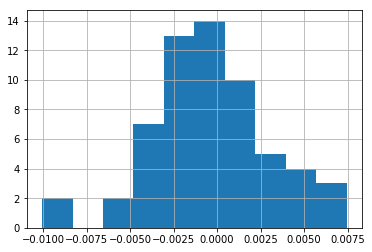

In [497]:
stock_regressions['DUK'].OLS_noint_resid.hist()

Next, find the out-of-sample MSE (mean squared error) for each of the 12 regressions, store them in one dataframe with tickers as the index, and save it as _results.csv_.

In [498]:
# calculate MSEs for each ticker
def calculate_mse(stock_regressions):
    # takes in dictionary with keys=tickers and values=dataframe
    t0 = time.time()
    cols=['OLS_noint_resid','OLS_noint_resid_norm','OLS_int_resid','OLS_int_resid_norm',
          'Huber_noint_resid','Huber_noint_resid_norm','Huber_int_resid','Huber_int_resid_norm',
          'Tukey_noint_resid','Tukey_noint_resid_norm','Tukey_int_resid','Tukey_int_resid_norm']

    # initilise dataframe with index of tickers
    results = pd.DataFrame(data={'Ticker':[k.replace('/','') for k in list(stock_regressions.keys())]})
    
    # initialize columns
    for c in cols:
        results[c]=0.
    
    # make Ticker the index
    results.set_index('Ticker', inplace=True)
    
    # for each ticker
    for key, value in stock_regressions.items():
        # select out-of-sample
        data = stock_regressions[key].iloc[45:,:]
        
        # clean ticker
        ticker = key.replace('/','')
        
        # for each model residuals needed
        for col in results.columns.tolist():
            if col=='Ticker': continue
            else:
                # compute MSE
                rmse = np.sqrt((data[col]**2).mean())
                # update MSE
                results.at[ticker,col] = rmse
                
    print('Running time: {} secs'.format(round(time.time()-t0,2), 'seconds'))
    return results

In [200]:
rmse_by_ticker = calculate_mse(stock_regressions)

# save as csv to avoid running code
rmse_by_ticker.to_csv('rmse_by_ticker.csv', index=True)

rmse_by_ticker.head()

Running time: 8.77 secs


,OLS_noint_resid,OLS_noint_resid_norm,OLS_int_resid,OLS_int_resid_norm,Huber_noint_resid,Huber_noint_resid_norm,Huber_int_resid,Huber_int_resid_norm,Tukey_noint_resid,Tukey_noint_resid_norm,Tukey_int_resid,Tukey_int_resid_norm
Ticker,,,,,,,,,,,,
A,0.006005,0.894652,0.006767,1.012882,0.006782,0.973997,0.006946,1.000340,0.013427,1.028400,0.013427,1.028400
AAP,0.017887,0.920279,0.017904,0.921174,0.017318,0.885733,0.017197,0.879722,0.017866,0.905128,0.017866,0.905128
ABBV,0.007832,0.543057,0.008314,0.578820,0.006748,0.453695,0.007233,0.482696,0.010087,0.548183,0.010087,0.548183
ABG,0.009339,0.689191,0.010334,0.763719,0.009811,0.720893,0.010839,0.787642,0.014525,0.807697,0.014525,0.807697
ABT,0.005837,0.661526,0.006044,0.685765,0.006095,0.674511,0.007041,0.797049,0.010421,0.692983,0.010421,0.692983


# Results

Import the results from csv.

In [329]:
results_1 = pd.read_csv('rmse_by_ticker.csv', index_col=0)
#results_1 = results_1**.5
results_1.head()

,OLS_noint_resid,OLS_noint_resid_norm,OLS_int_resid,OLS_int_resid_norm,Huber_noint_resid,Huber_noint_resid_norm,Huber_int_resid,Huber_int_resid_norm,Tukey_noint_resid,Tukey_noint_resid_norm,Tukey_int_resid,Tukey_int_resid_norm
Ticker,,,,,,,,,,,,
A,0.006005,0.894652,0.006767,1.012882,0.006782,0.973997,0.006946,1.000340,0.013427,1.028400,0.013427,1.028400
AAP,0.017887,0.920279,0.017904,0.921174,0.017318,0.885733,0.017197,0.879722,0.017866,0.905128,0.017866,0.905128
ABBV,0.007832,0.543057,0.008314,0.578820,0.006748,0.453695,0.007233,0.482696,0.010087,0.548183,0.010087,0.548183
ABG,0.009339,0.689191,0.010334,0.763719,0.009811,0.720893,0.010839,0.787642,0.014525,0.807697,0.014525,0.807697
ABT,0.005837,0.661526,0.006044,0.685765,0.006095,0.674511,0.007041,0.797049,0.010421,0.692983,0.010421,0.692983


# Analysis
These regressions were run with parameters (thresholds) of 0.003 for both Huber and Tukey regressions. This value was chosen since it lied roughly around the 75th and 25th percentiles for the residuals in the default-parameter regressions. More will be tested later.

Next we compare the performance of the 6 estimators on the out-of-sample set using the residuals.

## Out-of-sample residuals

In [330]:
results_1.head()

,OLS_noint_resid,OLS_noint_resid_norm,OLS_int_resid,OLS_int_resid_norm,Huber_noint_resid,Huber_noint_resid_norm,Huber_int_resid,Huber_int_resid_norm,Tukey_noint_resid,Tukey_noint_resid_norm,Tukey_int_resid,Tukey_int_resid_norm
Ticker,,,,,,,,,,,,
A,0.006005,0.894652,0.006767,1.012882,0.006782,0.973997,0.006946,1.000340,0.013427,1.028400,0.013427,1.028400
AAP,0.017887,0.920279,0.017904,0.921174,0.017318,0.885733,0.017197,0.879722,0.017866,0.905128,0.017866,0.905128
ABBV,0.007832,0.543057,0.008314,0.578820,0.006748,0.453695,0.007233,0.482696,0.010087,0.548183,0.010087,0.548183
ABG,0.009339,0.689191,0.010334,0.763719,0.009811,0.720893,0.010839,0.787642,0.014525,0.807697,0.014525,0.807697
ABT,0.005837,0.661526,0.006044,0.685765,0.006095,0.674511,0.007041,0.797049,0.010421,0.692983,0.010421,0.692983


The MSE was calculated for the six estimators (OLS, Huber, Tueky with an intercept and without, with standardization by in-sample standard error and without) on all 309 tickers. The results are shown above. Next, the root was taken and the mean of RMSE was taken across all 309 tickers. 

#### Weakness of RMSE
It should be noted that the returns are not all on exactly the same scales across companies, so neither are the RMSEs. So some companies' RMSE could contribute more to the average MSE just because its returns happened to be generally larger, not because the model performed worse. That being said, we are averaging over all the companies so the averaged results should still be comparable. Moreover, if all companies have roughly the same volatility, then they will also have daily returns that are roughly on the same scale. Conversely, different volatilities means some companies returns would swing wildly and be on a larger scale that quiter companies. We do not investigate that question here. And one solution would be to make the returns to have the scale by normalizeing the predictor variables before running the regressions. But we do not do that here.

Having different scales of the daily returns is bad because it's possible that a company with small-magnitude returns could hide poor estimator performance; the RMSE is small due to small-magnitude returns, not due to good performance. Similarly, it's possible that a company with high-magnitude returns could hide a high-performing estimator. These are downsides of the RMSE performance metric; these problems could be avoided a metric that doesn't depend on the scale of the underlying returns would avoid these problems. Indeed, other performance metrics will be investigated later. For this analysis, we use the RMSE and rely on averaging over multiple identical companies to average out the MSE's misrepresentations of performance.

Now we compare the performance of the 3 estimators, and the performance with and without intercept variables.

In [367]:
def plot_results_by_estimator(results_1, zoom=False, bottom=0.88, top=0.96, normalized=False):
    # data to plot
    n_groups = 3
    if normalized==False:
        means_noint = results_1.mean()[[0,4,8]] #(90, 55, 40, 65)
        means_int = results_1.mean()[[2,6,10]] #(85, 62, 54, 20)
    elif normalized==True:
        means_noint = results_1.mean()[[1,5,9]] #(90, 55, 40, 65)
        means_int = results_1.mean()[[3,7,11]] #(85, 62, 54, 20)

    # create plot
    fig, ax = plt.subplots()
    index =  np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(index, means_noint, bar_width,
                     alpha=opacity,
                     #color='b',
                     label='No intercept')

    rects2 = plt.bar(index + bar_width, means_int, bar_width,
                     alpha=opacity,
                     #color='g',
                     label='Intercept')

    if zoom: 
        plt.ylim(bottom, top)
        plt.annotate('...zoomed in', xy=(0.75, 0.92), xycoords='axes fraction')
    plt.xlabel('Estimator')
    plt.ylabel('mean RMSE')
    if normalized: plt.title('Out-of-sample mean RMSE by estimator (normalized)')
    else: plt.title('Out-of-sample mean RMSE by estimator (unnormalized)')
    plt.xticks(index + bar_width/2, ('OLS', 'Huber', 'Tukey'))
    plt.legend(loc='lower right', framealpha=1)

    plt.tight_layout()
    if normalized: print(results_1.mean()[[1,3,5,7,9,11]]) 
    else: print(results_1.mean()[[0,2,4,6,8,10]]) 
    plt.show()

In [ ]:
plot_results_by_estimator(results_1, zoom=False, bottom=0.88, top=0.96, normalized=False)

Let's zoom in to see the differences better.

OLS_noint_resid      0.012610
OLS_int_resid        0.012858
Huber_noint_resid    0.012422
Huber_int_resid      0.012607
Tukey_noint_resid    0.018079
Tukey_int_resid      0.018875
dtype: float64


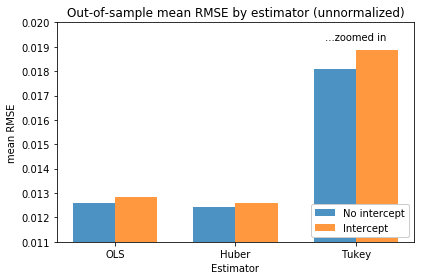

In [369]:
plot_results_by_estimator(results_1, zoom=True, bottom=0.011, top=0.02, normalized=False)

**Observations**:
* It's hard to say whether the differences across the three estimators are "large" or not in an absolute sense. The magnitude of the MSE depends on the magnitude of the target variables, as discussed above. We will investigate only the relative performance of the estimators.
* The Tukey estimator performed the worst (highest mean RMSE). This suggests that there the most extreme points in the trainig set should have been given higher weight and penalized larger than the Tukey esimator does. Recall that the Tukey estimator gives larger weight to farther points but after some distance it stops adding on more weight. So the farthest points are penalized just as much as the mildly-far points. The worse performance of Tukey suggest these points were important and represented relationships that showed up in the test set. Since the relationships weren't captured, Tukey performed worse.
* OLS and Huber performed roughly the same. One possible explanation is that there were few "far" points, that is, there the farthest points were penalized similarly in the loss function of OLS and Huber, resulting in very similar straight line fits. This is inconsistent with the message from Tukey, which said that there were some very extreme points that were being underpenalized. This result says that there weren't many extreme points to even worry about.
* The models _without_ intercepts (blue) performed better than models _with_ intercepts (orange). This is surprising. I would have expected that the stock's returns had some return that was not captured in their ETF's returns. There should be some "unexplained" part.
* From a pure modeling point of view, using the intercept makes the model more flexible, which can avoid underfitting but risks overfitting. It's usually unclear from a theory which model will be better; and it should be determined empirically via out-of-sample performance. Since the model with an intercept performed better out-of-sample, including the intercept term is better.
* It should be noted that the Huber and Tueky estimators do not account for the fact the the different input features might be at different scales. It this specific task, the inputs should be roughly at the same scale since they are all returns of ETFs, but a more careful analysis would standardize the inputs before running the regressions. 

Next we will normalize the out-of-sample residuals and re-analyze the results.

## Out-of-sample residuals, _normalized_

We normalized the residuals by dividing by the standard deviation of the in-sample residuals. This addresses the issue of the MSE of each regression being at different scales. Now each ticker's MSE should contribute the _appropriate_ amount to the mean RMSE. These results should be more reliable than the un-normalized results above.

OLS_noint_resid_norm      0.930475
OLS_int_resid_norm        0.947665
Huber_noint_resid_norm    0.905355
Huber_int_resid_norm      0.921490
Tukey_noint_resid_norm    0.928851
Tukey_int_resid_norm      0.951127
dtype: float64


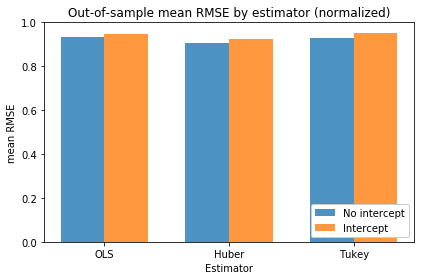

In [370]:
plot_results_by_estimator(results_1, zoom=False, bottom=0.88, top=0.96, normalized=True)

OLS_noint_resid_norm      0.930475
OLS_int_resid_norm        0.947665
Huber_noint_resid_norm    0.905355
Huber_int_resid_norm      0.921490
Tukey_noint_resid_norm    0.928851
Tukey_int_resid_norm      0.951127
dtype: float64


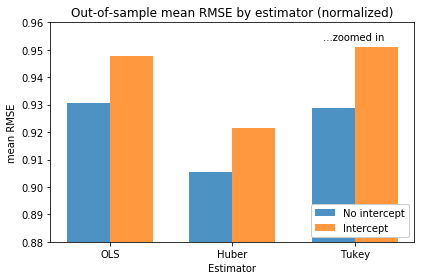

In [371]:
plot_results_by_estimator(results_1, zoom=True, bottom=0.88, top=.96, normalized=True)

**Observations**:
* During normalization, the residual returns were divided by a small number, resutling in larger values. We can see the mean RMSE are of the order 1, instead of $10^{-2}$, and they have nice interpretations. The typical RMSE should be roughly equal to one, since the residuals were normalized. The RMSEs are slightly less than one though, suggesting that the out-of-sample residuals had smaller standard deviation than the in-sample residuals. I don't see a reason why this would be true, but the data seem to show it.
* Now the Huber estimator performs the best, with OLS and Tukey being roughly equally poor. This suggests that there were some data points that were extreme enough to discount, but should be discounted only a little compared to OLS, not discounted heavily like Tukey does.
* The fact that the performance changed suggests that averaging the RMSE was in fact sensitive to the scale issues described above. Normalizing corrected for these issues. Another approach would be to normalized all the input variables before running the regressions so they all have the same scale. The word "Normalizing" usually means making the values lie between 0 and 1, but here it means to make the value have standard deviation one.
* Note that if the scale parameter were very larger, the outliers would be treated the same in the robust models as the OLS, because they would fall in the region where the loss function is the same for OLS and the robust models. We could decrease this parameter until the model cares almost solely about the data points near the the regression function and cares very little about the far points. And it's not clear whether this would perform better; it just depends on the observed distribution of the error term. There are scenarios when certain distrubitons and models would work better but we often cannot tell which scenario we are in until we find the best model. So we just select the model which performs best out-of-sample and conclude the data was such that it would lead to that being the best model. A sort of post-hoc rationalization.

# Tuning Parameters in Huber and Tukey
Now we will find the optimal cutoff values _k_ of the Huber and Tukey regressions. We will compare performance based on the normalized residuals with no intercepts, since the models with no intercepts seemed to perform best.

We perform a simple grid search to optimize these hyperparamters. Keep in miind that these parameters are optimized over all 309 datasets; they are not optimal on any one dataset.

In [245]:
def tune_hyperparams(ticker_returns_copy):
    optimal_huber_param = np.nan
    optimal_tukey_param = np.nan
    lowest_rmse_huber = np.nan
    lowest_rmse_tukey = np.nan
    optimal_huber_rmse_by_ticker = np.nan
    optimal_tukey_rmse_by_ticker = np.nan
    params_huber_list = [0.06,0.07,0.08]
    params_tukey_list = [0.02,0.03,0.04]
    for i, k in enumerate(params_huber_list):
        k_tukey = params_tukey_list[i]
        print(k, k_tukey)
        ticker_returns_2 = run_regression(ticker_returns_copy, huber_param=k, tukey_param=k_tukey)
        rmse_by_ticker_2 = calculate_mse(ticker_returns_2)
        print('k: {} | Huber mean RMSE: {} | Tukey mean RMSE: {}'.format(k, rmse_by_ticker_2.mean()[[5]][0], rmse_by_ticker_2.mean()[[9]][0]))
        if i==0:
            print(rmse_by_ticker_2.mean()[[5]][0])
            optimal_huber_param = k
            optimal_tukey_param = k_tukey
            optimal_huber_rmse_by_ticker = rmse_by_ticker_2.copy()
            optimal_tukey_rmse_by_ticker = rmse_by_ticker_2.copy()
            lowest_rmse_huber = rmse_by_ticker_2.mean()[[5]][0].copy()
            lowest_rmse_tukey = rmse_by_ticker_2.mean()[[9]][0].copy()
            print('Initializing lowest for Tukey and Huber')
        if lowest_rmse_huber > rmse_by_ticker_2.mean()[[5]][0]:
            optimal_huber_param = k
            optimal_huber_rmse_by_ticker = rmse_by_ticker_2
            lowest_rmse_huber = rmse_by_ticker_2.mean()[[5]][0]
            print('New lowest Huber')
        if lowest_rmse_tukey > rmse_by_ticker_2.mean()[[9]][0]:
            optimal_tukey_param = k_tukey
            optimal_tukey_rmse_by_ticker = rmse_by_ticker_2
            lowest_rmse_tukey = rmse_by_ticker_2.mean()[[9]][0]
            print('New lower Tukey')
        print('Done {}'.format(k))    
    return optimal_huber_param, optimal_tukey_param, lowest_rmse_huber, lowest_rmse_tukey, optimal_huber_rmse_by_ticker, optimal_tukey_rmse_by_ticker

In [249]:
optimal_huber_param, optimal_tukey_param, lowest_rmse_huber, lowest_rmse_tukey, optimal_huber_rmse_by_ticker, optimal_tukey_rmse_by_ticker = tune_hyperparams(ticker_returns_copy)

0.06 0.02
Running 3 regressions for 309 tickers:
Running time: 52 secs
Running time: 3.53 secs
k: 0.06 | Huber mean RMSE: 0.9052352625021405 | Tukey mean RMSE: 0.9131189571311285
0.9052352625021405
Initializing lowest for Tukey and Huber
Done 0.06
0.07 0.03
Running 3 regressions for 309 tickers:
Running time: 52 secs
Running time: 3.14 secs
k: 0.07 | Huber mean RMSE: 0.9052026240143048 | Tukey mean RMSE: 0.9082966962457049
New lowest Huber
New lower Tukey
Done 0.07
0.08 0.04
Running 3 regressions for 309 tickers:
Running time: 50 secs
Running time: 3.25 secs
k: 0.08 | Huber mean RMSE: 0.9052314603103921 | Tukey mean RMSE: 0.9139032312315927
Done 0.08


In [250]:
print('Optimal Huber parameter is {} with mean RMSE {}'.format(optimal_huber_param, round(lowest_rmse_huber,3)))
print('Optimal Tukey parameter is {} with mean RMSE {}'.format(optimal_tukey_param, round(lowest_rmse_tukey,3)))

Optimal Huber parameter is 0.07 with mean RMSE 0.905
Optimal Tukey parameter is 0.03 with mean RMSE 0.908


Next, we'll demonstrate which datasets perform better with robust regression and which perform better iwth OLS.

# Now try $R^2$
Now we will measure performance using $R^2$ instead of RMSE. Also, we will take the 20th percentile value of $R^2$ across tickers, rather than the mean. The rationale is we want to optimize performance on the worse performing regressions, not the average regression.

In [573]:
# calculate R-sqaured for each ticker

from sklearn.metrics import r2_score

def calculate_rsquared(stock_regressions):
    # takes in dictionary with keys=tickers and values=dataframe
    t0 = time.time()
    cols = ['OLS_noint_Y_pred_out_samp',
            'OLS_int_Y_pred_out_samp',
            'Huber_noint_Y_pred_out_samp',
            'Huber_int_Y_pred_out_samp',
            'Tukey_noint_Y_pred_out_samp',
            'Tukey_int_Y_pred_out_samp']

    # initilise dataframe with index of tickers
    results = pd.DataFrame(data={'Ticker':[k.replace('/','') for k in list(stock_regressions.keys())]})
    
    # initialize columns
    for c in [co.replace('_Y_pred_out_samp','') for co in cols]: # ['OLS_noint','OLS_int','Huber_noint','Huber_int','Tukey_noint','Tukey_int']:
        results[c]=0.
    
    # make Ticker the index
    results.set_index('Ticker', inplace=True)
    
    # for each ticker
    for key, value in stock_regressions.items():
        
        # clean ticker
        ticker = key.replace('/','')
        
        # select out-of-sample
        data = stock_regressions[key].iloc[45:,:].loc[:,[ticker]+cols].copy()
        
        # for each model residuals needed
        for col in results.columns.tolist():
            if col=='Ticker': continue
            else:
                # compute R2
                r2 = r2_score( data.loc[:,ticker].values , data.loc[:,col+'_Y_pred_out_samp'] )
                 
                # update R2
                results.at[ticker,col] = r2
        
    print('Running time: {} secs'.format(round(time.time()-t0,2), 'seconds'))
    return results

In [574]:
#ticker_returns_2 = run_regression(ticker_returns_copy, huber_param=0.07, tukey_param=0.03)

# save as csv to avoid running code
#rsquared_by_ticker.to_csv('rsquared_by_ticker.csv', index=True)

In [575]:
rsquared_by_ticker_2 = calculate_rsquared(ticker_returns_2)

Running time: 3.67 secs


In [577]:
rsquared_by_ticker_2.head()

,OLS_noint,OLS_int,Huber_noint,Huber_int,Tukey_noint,Tukey_int
Ticker,,,,,,
NEE,0.857270,0.848256,0.873062,0.874613,-0.071243,-0.594898
DUK,0.820498,0.825390,0.794696,0.799758,-0.002158,-0.002158
D,0.499016,0.508339,0.512398,0.430811,-0.003205,-0.003205
SO,0.836831,0.801843,0.840707,0.772795,0.372263,-0.056872
EXC,0.869144,0.873900,0.892463,0.895381,-0.038164,-0.071010


Now let's plot the historgrams of the $R^2$ values across tickers to get a sense of their values, and compare across the three estimators.

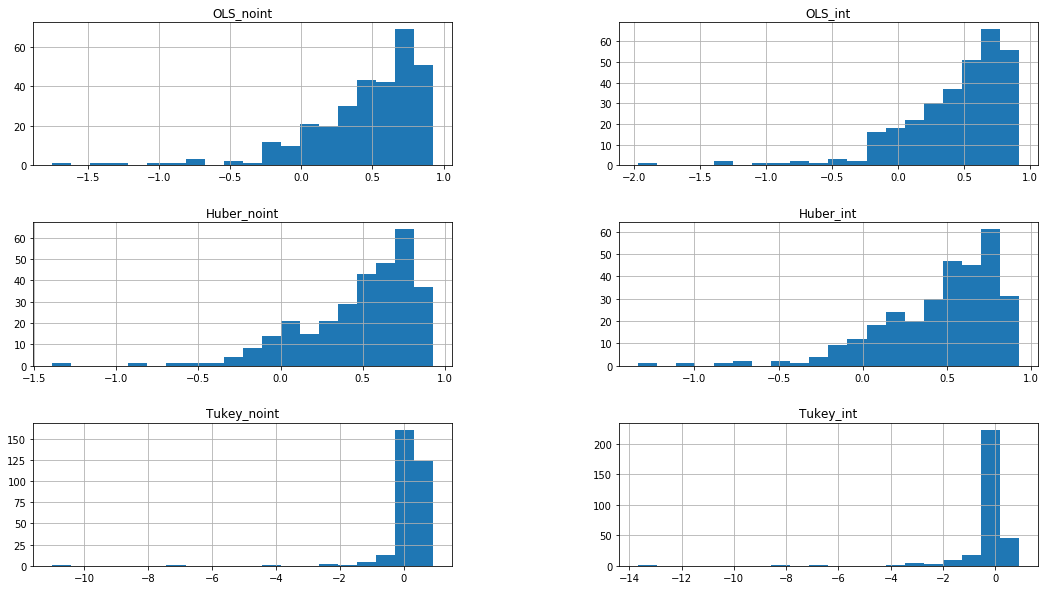

In [610]:
fig = plt.figure(figsize=(18,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 7):
    ax = fig.add_subplot(3, 2, i)
    ax.hist(rsquared_by_ticker_2.iloc[:,i-1],bins=20)
    ax.set_title(rsquared_by_ticker_2.columns.tolist()[i-1])
    ax.grid()
    #ax.text(0.5, 0.5, str((2, 3, i)),
    #       fontsize=18, ha='center')

Observations:
* Both the OLS and Huber estimators seem to have most of their weight above 0, with a small number of regressions giving $R^2$ values far less than zero. This represents regression where the predictions are worse than predicting the mean of the out-of-sample set (it's impossible to know the mean of the out-of-sample set when we make the predictions, but using the in-sample mean would be a pretty good guess). Needless to say, negaitive $R^2$ values represents very poor performance.
* The Tueky with no intercept seems to have most of its weight above 0, but the Tukey with the intercept seems to have most of the regressions with $R^2$ values _below_ zero. this indicates very poor performance by Tukey, which is what we also observed from the RMSE.
* We used the "optimal" parameters for Huber and Tukey. However, these might not be optimal because the Tukey and Huber with optimal parameters should perform as good or better than OLS; if the parameters are very large then Huber/Tukey are equivalent to OLS. Therefore, a large range of parameter values should be tried to find the true optimum, not a local optimum (or at least a better local optimum).

## Datasets with outliers
* **Hypothesis**: Robust regression should outperform on datasets with many in-sample outliers, but few out-of-sample outliers. Similarly, OLS should outperform robust regression on datasets with very outliers in both in-sample and out-of-sample sets.
* To find such tickers:
  * we will run OLS, Huber, Tukey on all tickers.
  * Standardize the residuals by dividing by their standard deviation (the mean should already have zero).
  * Select tickers that have more than 10% of in-sample residuals above 4, and less than 1% of ou-of-sample residuals above 2. On this subset of tickers, robust methods should outperform OLS.
  * Select tickers have fewer than 1% of in-sample and out-of-sample residuals above 2. On these tickers, OLS should outperform robust methods.
  * Now, select tickers than have fewer than 1% of in-sample residuals above 2, and more than 10% of out-of-sample residuals above 4. For these tickers, it's not clear which methods would perform best. It's possible that the small-outliers could be somewhat predictive of larger outliers, then robust methods would outperform. On the other hand, it's possible that the in-sample datapoints don't predict the large outliers in the out-fo-sample set at all; then both methods would perform equally.
* Then select tickers which have very few outliers in both the in-sample and out-of-sample sets. For these tickers, OLS should outperform huber and Tukey.
* I only outline this test; I'm not going to perform it due to time constraints. Also, there are probably better ways to find outliers than my methods. One reason is that the OLS can "mask" an outlier by twisting hard to fit it. Even though it's an outlier that has large leverage, it may not have a large residual. So my test might not be best for detecting outliers.

# Add LASSO
Next, we'll add LASSO to the list of models. LASSO helps when the model is overfitting by lowering the capacity of the model i.e. regularization. LASSO add a sum of sqaured weights term to the loss function which is optimized during training: $loss = \frac{1}{n}\sum_i^N (\hat y_i - y_i)^2 + \lambda \sum_j |W_{j}|)$. This regularization term is the L1-norm of the weights vector, and the strength of the regularization is controlled by the parameter $\lambda$. For large $\lambda$, large weights are penalized heavily and thus shrink to small values. The set of possible values is reduced. Conversely, when $lambda$ is small the weights are free to remain large. And if $\lambda = 0$, then the model reduces to standard linear regression. The hyperparameter $\lambda$ must be selected by choosing the value which performs best on a test set. LASSO can also be written as a Bayesian regression with independent identical Laplace (double-exponential) priors. However, I find the regularization-term formulation more intuitive.

## Changes
LASSO is compared to OLS, Huber, and Tukey but with a few twists.  
* The input features are standardized before training the models. The test set features are standardized using the training set mean and standard deviation. This standardization removes the need to divide the residuals of the test set by the standard deviation of the residuals of the training set, as was done previously. All the features are on the same scale, so later standardization should not be needed.
* For each regression (ticker) of Huber and LASSO, a grid search is used to choose the optimal value of the distance parameters (huber) and regularization parameter (LASSO). This is because these two models are implemented in Scikit-Learn, which has easy functions to optimize hyperparameters with grid search. 
* Tukey is not implemented in Scikit-Learn, and I couldn't get it to fit in a sklearn estimator in a way that would allow similar grid search. Therefore, Tukey regression is always run with a value of 1.0, which is one standard deviation if the returns are normal.

## Predictions
Which model with perform best? LASSO is ussually used to address a different problem than Huber/Tukey. LASSO helps fight overfitting while Huber/Tukey help fight oversensitivity to outliers in the training set. However, there is reason to think that LASSO can help fight oversensitivity to outliers in the training, because LASSO helps fight oversitivity to _all_ samples in the training set. Any data point or curve that appears in the training set but not the test set will be "discounted" or "ignored" by the LASSO. When the LASSO regularization term appears, it constrains the direction and location of the fitted hyper-plane. So, it can constrain the hyperplane to prevent it from perturbing to reach outliers in the training set.  

LASSO also performs variable selection by reducing some of parameter coefficients down to zero. As such, it reduces sensitivity to features that to not "appear" in the test set. This is an added feature of LASSO; Huber and Tukey do not offer this protection against fitting unpredictive features. Therefore, I predict that LASSO will outperform Huber (recall that we won't be finding optimal hyperparamters for Tukey, so we can't draw many conclusions from its results).

In [454]:
# load returns_by_ticker dictionary
with open('returns_by_ticker.pickle', 'rb') as handle:
    returns_by_ticker = pickle.load(handle)

print(len(returns_by_ticker))

309


In [455]:
df = returns_by_ticker['NEE'].copy()
df.head()

,NEE,QQQ,SPY,XLU
Date,,,,
2019-01-02,NaN,NaN,NaN,NaN
2019-01-03,-0.002473,-0.032670,-0.023863,-0.000192
2019-01-04,0.018417,0.042785,0.033496,0.014808
2019-01-07,-0.001449,0.011906,0.007885,-0.006822
2019-01-08,0.007314,0.009045,0.009395,0.012402


## DEPRECATED
This was my failed attempt to turn Tukey from statsmodels into a scikit-learn estimator.

In [266]:
# https://stackoverflow.com/questions/41045752/using-statsmodel-estimations-with-scikit-learn-cross-validation-is-it-possible

import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [326]:
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

X, y = make_regression(random_state=1, n_samples=300, noise=100)

huber_t = sm.RLM(X, y, M=sm.robust.norms.HuberT())

print(cross_val_score(SMWrapper(sm.RLM), X, y, scoring='r2'))
print(cross_val_score(LinearRegression(), X, y, scoring='r2'))

[0.27590772 0.38541996 0.45140208]
[0.28592315 0.37367557 0.47972639]


/Users/roberthatem/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [389]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm
 
class statsmodel(BaseEstimator, RegressorMixin):
    def __init__(self, sm_class, c, fit_intercept=True):
        self.sm_class = sm_class
        #self.formula = formula
        self.M = sm.robust.norms.TukeyBiweight(c=c)
        self.fit_intercept = fit_intercept
        self.model = None
        self.result = None
 
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model = self.sm_class(y, X)
        self.result = self.model.fit()
 
    def predict(self,X):
        return self.result.predict(X)

...continue

This function finds the optimal hyperparameters of the three regressions (excluding Tukey), and returns the test $R^2$ from the optimal hyperparameter.

In [17]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import statsmodels.api as sm

def optimal_r_squared(df, reg_type = 'linear', fit_intercept=True):

    X = df.dropna().iloc[:,1:].values.copy() #.reshape(-1,1)
    y = df.dropna().iloc[:,0].values.copy()

    # standardize inputs, based on training set
    scaler = StandardScaler().fit(X[0:30])
    X[0:30] = scaler.transform(X[0:30])
    X[30:45] = scaler.transform(X[30:45])

    # https://stackoverflow.com/questions/48390601/explicitly-specifying-test-train-sets-in-gridsearchcv
    # The indices which have the value -1 will be kept in train.
    train_indices = np.full((30,), -1, dtype=int)

    # The indices which have zero or positive values, will be kept in test
    test_indices = np.full((15,), 0, dtype=int)
    test_fold = np.append(train_indices, test_indices)

    ps = PredefinedSplit(test_fold)
    
    if reg_type=='linear':
        reg = linear_model.LinearRegression(fit_intercept=fit_intercept).fit(X[0:30], y[0:30])
        return reg.score(X[30:45], y[30:45])
    
    elif reg_type=='huber':
        parameters = {'epsilon': [1.01,1.2,1.35, 1.5, 1.75, 1.9,2,3,4,5,7,10,20]}
        huber = linear_model.HuberRegressor(fit_intercept=fit_intercept, alpha=0.0)
        clf = GridSearchCV(huber, parameters, scoring='r2', cv=ps)  # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
        clf.fit(X, y)
        return clf.best_score_
    
    elif reg_type=='tukey':
        #parameters = {'c': [4.684, 5,6]}
        #parameters = {'M': [sm.robust.norms.TukeyBiweight(c=4.684)] }
        
        #clf = statsmodel(smf.ols, "AVGEXP ~ AGE + INCOME")
        #tukey = statsmodel(sm.RLM, c=4.684)
        if fit_intercept==True:
            X = sm.add_constant(X)
        
        model = sm.RLM(y[0:30], X[0:30], missing='drop', M=sm.robust.norms.TukeyBiweight(c=1.0))  # default is 4.684
        
        #clf = GridSearchCV(tukey, parameters, scoring='r2', cv=ps)  # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
        #clf.fit(X, y)
        results = model.fit()
        y_pred = model.predict(results.params, X[30:45]) 
        #clf.best_score_
        return r2_score(y[30:45], y_pred)

    elif reg_type=='lasso':
        parameters = {'alpha':np.logspace(-7, -0.1, 20)}
        lasso = linear_model.Lasso(fit_intercept=fit_intercept)
        clf = GridSearchCV(lasso, parameters, scoring='r2', cv=ps)
        clf.fit(X, y)
        return clf.best_score_


In [492]:
result = optimal_r_squared(df, reg_type = 'tukey', fit_intercept=True)
print(result)

0.12443687722668084


This function takes in the dataframe for one ticker and returns the optimal test $R^2$ for all four regressions as a dictionary.

In [493]:
def optimal_r_squared_one_ticker(df):
    result = {}
    result['Linear_noint'] = optimal_r_squared(df, reg_type = 'linear', fit_intercept=False)
    result['Linear_int'] = optimal_r_squared(df, reg_type = 'linear', fit_intercept=True)
    result['Huber_noint'] = optimal_r_squared(df, reg_type = 'huber', fit_intercept=False)
    result['Huber_int'] = optimal_r_squared(df, reg_type = 'huber', fit_intercept=True)
    result['Tukey_noint'] = optimal_r_squared(df, reg_type = 'tukey', fit_intercept=False)
    result['Tukey_int'] = optimal_r_squared(df, reg_type = 'tukey', fit_intercept=True)
    result['Lasso_noint'] = optimal_r_squared(df, reg_type = 'lasso', fit_intercept=False)
    result['Lasso_int'] = optimal_r_squared(df, reg_type = 'lasso', fit_intercept=True)
    return result #pd.DataFrame(index=[0],data=result)

In [494]:
# example
res = optimal_r_squared_one_ticker(df)
res

{'Linear_noint': -0.3937591296479607,
 'Linear_int': -0.016660665295743282,
 'Huber_noint': -0.3349135314679137,
 'Huber_int': 0.2987420612559931,
 'Tukey_noint': -0.4645945610765212,
 'Tukey_int': 0.12443687722668084,
 'Lasso_noint': -0.05463077784563031,
 'Lasso_int': 0.4628364180563608}

Finally, this function iterates through tickers, calculates the four optimal $R^2$s and returns them in one dataframe with tickers as the rows.

In [495]:
def optimal_r_squared_by_ticker(returns_by_ticker):
    # calculate R-sqaured for each ticker
    result = {'Linear_noint': [],
             'Linear_int': [],
             'Huber_noint': [],
             'Huber_int': [],
             'Tukey_noint': [],
             'Tukey_int': [],
             'Lasso_noint': [],
             'Lasso_int': []}
    
    ind = []
    
    for key, value in returns_by_ticker.items():
        ticker = key.replace('.','')
        #print(ticker)
        ind.append(ticker)
        df_copy = value.copy()
        r_squared = optimal_r_squared_one_ticker(df_copy)
        for col, r_sqr in r_squared.items():
            result[col].append(r_sqr)
    
    return pd.DataFrame(index=ind, data=result)

In [496]:
# example
df1 = optimal_r_squared_by_ticker(returns_by_ticker)
df1.head()

,Linear_noint,Linear_int,Huber_noint,Huber_int,Tukey_noint,Tukey_int,Lasso_noint,Lasso_int
NEE,-0.393759,-0.016661,-0.334914,0.298742,-0.464595,0.124437,-0.054631,0.462836
DUK,0.465139,0.547174,0.471914,0.547175,0.468258,0.533116,0.465095,0.547160
D,-0.165093,-0.027978,-0.114181,0.092647,-0.124011,0.111535,-0.107624,0.012283
SO,0.395828,0.500729,0.395828,0.500729,0.387117,0.488247,0.396268,0.500705
EXC,0.392026,0.440015,0.412684,0.440019,0.419103,0.216811,0.392205,0.460060


## Analysis

Plot histograms of the optimal $R^2$ values, with and without intercepts.

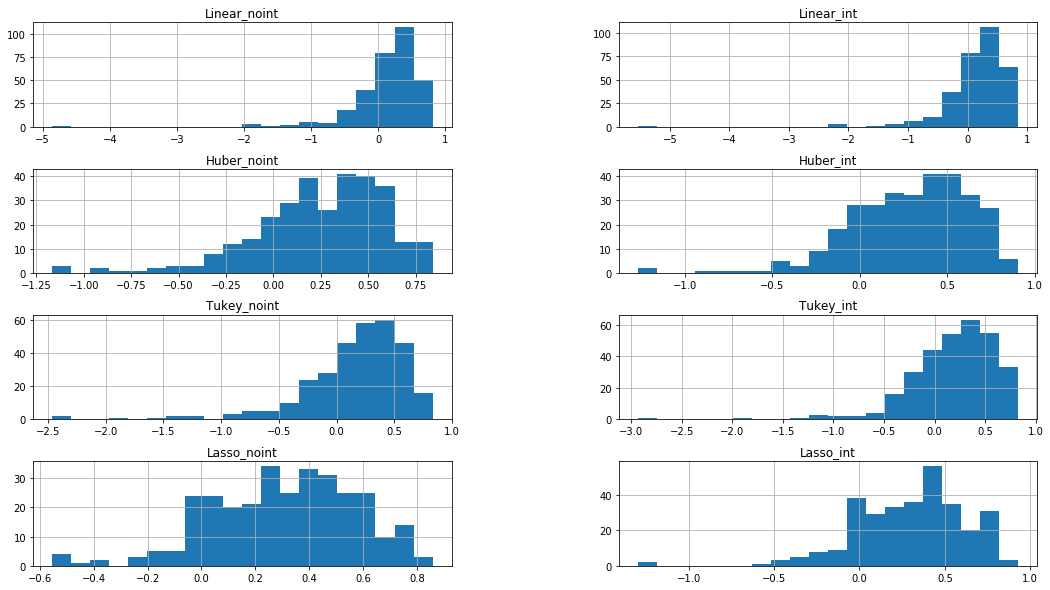

In [497]:
fig = plt.figure(figsize=(18,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 9):
    ax = fig.add_subplot(4, 2, i)
    ax.hist(df1.iloc[:,i-1],bins=20)
    ax.set_title(df1.columns.tolist()[i-1])
    ax.grid()
    #ax.text(0.5, 0.5, str((2, 3, i)),
    #       fontsize=18, ha='center')

Observations:
* All eight histograms show their weight centered above 0, meaning the regression performs better than predicting the target variable mean.
* However, Huber seems to have the largest mass below 0; even more than Tukey apparently. This suggests that Huber's parameter grid was poor. After adding in some more values to the grid, the same results appears, but less strongly. This result is very counter-intuitive; Tukey seems to be outperforming Huber even without any hyperparameter optimization.
* Linear regression appears to have smaller variance of $R^2$ than the other methods. LASSO especially has a large spread.
* The models with intercepts seem to outperform models without intercepts. For linear, Huber, and Tukey, this could be a cause of overfitting (having too many variables can often lead to overfitting). LASSO would not suffer from this problem because it has regularization to restrict the model and reduce overfitting.
* It's hard to tell which of the four models is performing the best. To get a more precise measure of accuracy, we will look at some specific percentile values. This will tell us how a typical "bad" model, "good", and typical dataset is performing under the different models.

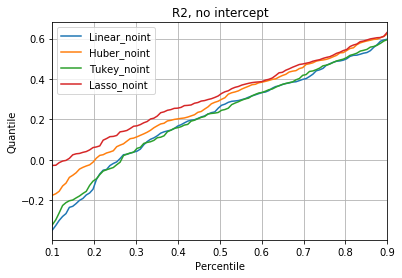

In [538]:
# quantiles, no intercept
df1.quantile(np.linspace(0.1,0.9,100), axis=0).iloc[:,[0,2,4,6]].plot()
plt.xlabel('Percentile')
plt.ylabel('Quantile')
plt.title('R2, no intercept');
plt.grid()

* Among the models with no intercept, LASSO performs the best. At (almost) all percentiles, the $R^2$ is highest among the four models (red line is highest). This is what we predicted above; refer to the previous section for the reasons. 
* Second best is Huber, which makes sense because it can simplify to linear regression with a hyperparameter large enough. The linear regression is the most restricted model, with no parameters to adjust, so it cannot be regularized to address outliers, heavy-tailed errors, or overfitting. The Tukey model performed worse than the the Huber, which is reassuring given that the hyperparameter was not optimized. 
* Even still, Tukey outperformed the linear regression, suggesting that the error distribution was heavy-tailed compared to the Gaussian, and thus benefitted from the Tukey loss (even if un-optimized).

Next we'll look at the models that have the intercept term.

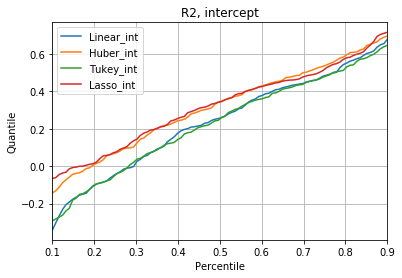

In [539]:
# quantiles, intercept
df1.quantile(np.linspace(0.1,0.9,100), axis=0).iloc[:,[1,3,5,7]].plot()
plt.xlabel('Percentile')
plt.ylabel('Quantile')
plt.title('R2, intercept')
plt.grid()

* The LASSO still performs well, but it gets beat by Huber for the higher percentiles of regressions. Tukey and OLS also overlap more, but are still clearly below LASSO and Huber.
* Overall, it seems that LASSO performs the best best on test $R^2$. It offers protection against overfitting to the patterns in the training set, outliers and more-extreme data pionts included. However, LASSO offers protection from outliers only if those outliers are above the y=0 plane because LASSO usually "flattens" the regression surface towards the y=0 plane. As such, LASSO will not help correct the surface from outliers if the correction needs to steepen the line. This is easy to see with one preictor variable, as shown below.

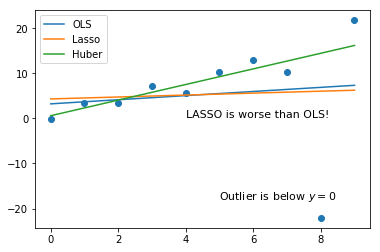

In [120]:
X = np.arange(10).reshape(-1,1)
y = 2*x + np.random.normal(0,2,10)
y[8] -= 40

X1 = X[[0,1,2,3,4,5,6,7,9]]
y1 = y[[0,1,2,3,4,5,6,7,9]]

reg = linear_model.LinearRegression().fit(X, y)
y_pred = reg.predict(X)

reg1 = linear_model.LinearRegression().fit(X1, y1)
y_pred1 = reg1.predict(X1)

reg2 = linear_model.Lasso(alpha=2).fit(X, y)
y_pred2 = reg2.predict(X)

reg3 = linear_model.HuberRegressor().fit(X, y)
y_pred3 = reg3.predict(X)


plt.scatter(X,y)
#plt.plot(X1,y_pred1)
plt.plot(X,y_pred)
plt.plot(X,y_pred2)
plt.plot(X, y_pred3)
plt.legend(['OLS','Lasso','Huber'])
plt.text(4, 0.2, r'LASSO is worse than OLS!', fontsize=11)
plt.text(5, -18, r'Outlier is below $y=0$', fontsize=11);

When the outlier is below the line $y=0$, the line should be pulled up. However, LASSO pulls the line down, making the outlier problem even worse. Huber outperforms in this scenario.

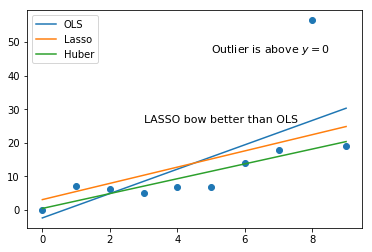

In [140]:
X = np.arange(10).reshape(-1,1)
y = 2*x + np.random.normal(0,2,10)
y[8] += 40

X1 = X[[0,1,2,3,4,5,6,7,9]]
y1 = y[[0,1,2,3,4,5,6,7,9]]

reg = linear_model.LinearRegression().fit(X, y)
y_pred = reg.predict(X)

reg1 = linear_model.LinearRegression().fit(X1, y1)
y_pred1 = reg1.predict(X1)

reg2 = linear_model.Lasso(alpha=10).fit(X, y)
y_pred2 = reg2.predict(X)

reg3 = linear_model.HuberRegressor().fit(X, y)
y_pred3 = reg3.predict(X)


plt.scatter(X,y)
#plt.plot(X1,y_pred1)
plt.plot(X,y_pred)
plt.plot(X,y_pred2)
plt.plot(X, y_pred3)
plt.legend(['OLS','Lasso','Huber'])
plt.text(3, 26, r'LASSO bow better than OLS', fontsize=11)
plt.text(5, 47, r'Outlier is above $y=0$', fontsize=11);

When the outlier is _above_ the line $y=0$, the line needs to be pulled down. LASSO fulfills the task by flattening the regression line. So LASSO beats OLS here. However, LASSO still gets beat by Huber. Stronger regularization tends to reduce the slope, but not lower the intercept term to match Huber's intercept.

This demonstrates a scenario where LASSO can provide protection against outliers, and one where it can't. Beyond outliers, LASSO can provide protection against features that aren't predictive in test sets. HUber cannot. This feature of LASSO might be a large reason why it outperforms Huber overall in our datasets.